DEBUG:cmdstanpy:input tempfile: /tmp/tmp6cu8i7ju/o81bo8s7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6cu8i7ju/hswvwb5u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=66022', 'data', 'file=/tmp/tmp6cu8i7ju/o81bo8s7.json', 'init=/tmp/tmp6cu8i7ju/hswvwb5u.json', 'output', 'file=/tmp/tmp6cu8i7ju/prophet_modelxxafqm0o/prophet_model-20250713072250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
07:22:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
07:22:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6cu8i7ju/oo492gr1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp6cu8i7ju/zst2h3te.json
DEBUG:cmdstanp

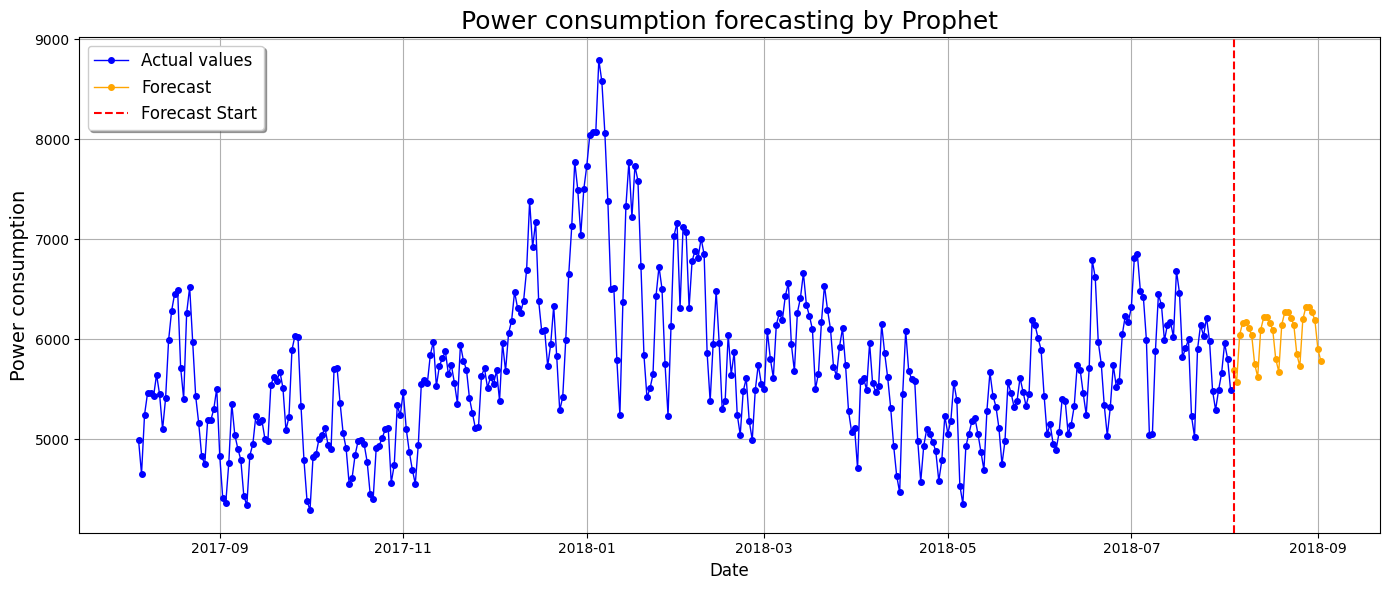


📊 Prophet Forecasted Error Metrics (train → test):
MAE  (Mean Absolute Error):      488.43
RMSE (Root Mean Squared Error):  657.78
MAPE (Mean Absolute % Error):    8.15%

📈 Prophet Forecast for Next 30 Days (test → future):
            ds         yhat   yhat_lower   yhat_upper
364 2018-08-04  5697.948563  5016.415287  6347.470898
365 2018-08-05  5573.932761  4916.775629  6207.863716
366 2018-08-06  6044.465462  5408.215014  6741.388745
367 2018-08-07  6166.650525  5513.071390  6840.939022
368 2018-08-08  6172.348362  5542.318106  6828.144651
369 2018-08-09  6114.042167  5477.569881  6792.436108
370 2018-08-10  6041.417292  5373.067188  6715.059086
371 2018-08-11  5749.547311  5096.732197  6404.340224
372 2018-08-12  5625.531509  4942.418987  6234.288092
373 2018-08-13  6096.064211  5484.523533  6715.976512
374 2018-08-14  6218.249273  5602.173846  6923.175573
375 2018-08-15  6223.947110  5555.351557  6842.710401
376 2018-08-16  6165.640915  5498.777188  6846.994569
377 2018-08-17  609

In [6]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# Load and prepare data
daily_data = pd.read_csv("daily_data.csv", parse_dates=True, index_col=0)
daily_data = daily_data.sort_index()
daily_data = daily_data.rename(columns={daily_data.columns[0]: "y"})
daily_data["ds"] = daily_data.index
daily_data = daily_data[["ds", "y"]]

# === Step 1: Split into train and test ===
cutoff = pd.to_datetime('2017-08-04')
train = daily_data[daily_data["ds"] <= cutoff]
test = daily_data[daily_data["ds"] > cutoff]

# === Step 2: Forecasted Error Metrics (train -> test) ===
model_forecast = Prophet(daily_seasonality=True)
model_forecast.fit(train)

future_test = model_forecast.make_future_dataframe(periods=len(test), freq='D')
forecast_test_full = model_forecast.predict(future_test)

# Align with actual test period
forecast_test = forecast_test_full.set_index("ds").loc[test["ds"]]

# Compute error metrics
y_true_forecast = test["y"].values
y_pred_forecast = forecast_test["yhat"].values

mae_forecast = mean_absolute_error(y_true_forecast, y_pred_forecast)
rmse_forecast = np.sqrt(mean_squared_error(y_true_forecast, y_pred_forecast))
mape_forecast = np.mean(np.abs((y_true_forecast - y_pred_forecast) / y_true_forecast)) * 100

# === Step 3: Predicted Forecast (test -> next 30 days) ===
model_predict = Prophet(daily_seasonality=True)
model_predict.fit(test)

future_30 = model_predict.make_future_dataframe(periods=30, freq='D')
forecast_30 = model_predict.predict(future_30)
forecast_next_30 = forecast_30[forecast_30["ds"] > test["ds"].max()]

# === Step 4: Plot Test + Next 30-day Forecast ===
plt.figure(figsize=(14, 6))
plt.title("Power consumption forecasting by Prophet", fontsize=18)

# Plot actual test values
plt.plot(test["ds"], test["y"], label='Actual values', color="blue", marker="o", markersize=4, linewidth=1)

# Plot forecast for next 30 days
plt.plot(forecast_next_30["ds"], forecast_next_30["yhat"], label='Forecast', color="orange", marker="o", markersize=4, linewidth=1)

# Red dashed line at forecast start
forecast_start = test["ds"].max() + pd.Timedelta(days=1)
plt.axvline(forecast_start, color="red", linestyle="--", linewidth=1.5, label="Forecast Start")

# Style plot
plt.ylabel("Power consumption", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.legend(fontsize=12, fancybox=True, frameon=True, shadow=True)
plt.grid(True)
plt.tight_layout()
plt.show()

# === Step 5: Print All Results ===
print("\n📊 Prophet Forecasted Error Metrics (train → test):")
print(f"MAE  (Mean Absolute Error):      {mae_forecast:.2f}")
print(f"RMSE (Root Mean Squared Error):  {rmse_forecast:.2f}")
print(f"MAPE (Mean Absolute % Error):    {mape_forecast:.2f}%")

print("\n📈 Prophet Forecast for Next 30 Days (test → future):")
print(forecast_next_30[["ds", "yhat", "yhat_lower", "yhat_upper"]])


